In [73]:
## import statements ##
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, f1_score

% matplotlib inline
sns.set_context('talk')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

import warnings; warnings.simplefilter('ignore')

**Import Data from XLS file**

Using pandas to import the dataset and transform into a Dataframe.

In [74]:
data_files = 'Comment Spam.xls'

data = pd.read_excel(data_files)
data = data[['Comment', 'Class']]
train_data = data
train_data.head()

,Comment,Class
0,this song is racist,0
1,and how many subscribers compared to her over ...,1
2,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1
3,well done shakira,0
4,:D subscribe to me for daily vines,1


In [75]:
train_data['Class'].value_counts()

1    669
0    631
Name: Class, dtype: int64

**Data Cleansing Step**

1. Remove any symbols in the comments,
2. Convert to lowercase.

In [76]:
def process_content(content):
    return " ".join(re.findall("[A-Za-z]+",content.lower()))

In [77]:
train_data['processed_comment'] = train_data['Comment'].apply(process_content)

In [78]:
train_data.head()

,Comment,Class,processed_comment
0,this song is racist,0,this song is racist
1,and how many subscribers compared to her over ...,1,and how many subscribers compared to her over ...
2,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1,hi check out our awesome covers and say what y...
3,well done shakira,0,well done shakira
4,:D subscribe to me for daily vines,1,d subscribe to me for daily vines


**Split the data**

Split the data for data training of 80% and data testing of 20% with random pick of 57.
- Data Training : `X_train & y_train`
- Data Testing : `X_test & y_test`

In [79]:
X_train, X_test, y_train, y_test = train_test_split(train_data['processed_comment'],train_data['Class'],test_size=0.2,random_state=57)

**Data Pipeline**

1. Data Cleansing using `CountVectorize` with stop_word='english' to remove the stop word
2. Data transforming using `TF-IDF`
3. Model Training using `LogisticRegression`

In [80]:
model = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression()),
                     ])

**Fitting the model**

In [81]:
model.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

**Predict the data testing**

In [82]:
predicted = model.predict(X_test)

**Confusion Matrix**

In [83]:
confusion_matrix(y_test,predicted)

array([[132,   7],
       [  8, 113]])

**Accuracy Score & Classification Report**

In [84]:
print('accuracy_score',accuracy_score(y_test,predicted))
print('Reporting...')

accuracy_score 0.9423076923076923
Reporting...


In [85]:
print(classification_report(y_test,predicted))

             precision    recall  f1-score   support

          0       0.94      0.95      0.95       139
          1       0.94      0.93      0.94       121

avg / total       0.94      0.94      0.94       260



**Model Evaluation using Cross Validation**

On the data training

In [86]:
cross_val_score(model, X_train, y_train, cv=5)

array([0.94258373, 0.95215311, 0.94230769, 0.93719807, 0.90821256])

On the data testing

In [87]:
cross_val_score(model, X_test, y_test, cv=5)

array([0.9245283 , 0.94230769, 0.90384615, 0.86538462, 0.94117647])

**New Data Sample Test**

In [88]:
c1 = ['Omg!']
content = pd.DataFrame(c1, columns=['Comment'])

In [89]:
test_data = pd.DataFrame(c1, columns=['Comment'])
test_data['processed_comment'] = test_data['Comment'].apply(process_content)
x_test_new = test_data['processed_comment']

model1.predict(x_test_new)

array([0], dtype=int64)

**Building Model with ROC Curve**

In [90]:
def accuracy_model_with_roc( dataframe, y1):
    models = {
        'lr': Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', LogisticRegression()),
                       ])
    }
    
    X_train, X_test, y_train, y_test = train_test_split(dataframe,y1,test_size=0.2,random_state=57)
    
    counter = 0
    f, ax = plt.subplots(1, 1)

    for index, model in models.items():
        clf = model

        func = clf.fit(X_train, y_train)
        pred = clf.predict_proba(X_test)[:,1]
        pred_class = clf.predict(X_test)

        fpr, tpr, _ = roc_curve(y_test, pred)
        
        roc_auc = auc( fpr, tpr )
        fscore = f1_score(y_test, pred_class, average='macro')
        
        ax.plot(fpr, tpr, label='ROC curve %s (area = %0.2f) \n fscore %s : %0.2f' % (index, roc_auc, index, fscore) )

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title('ROC Curve ')
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    counter = counter + 1
    plt.tight_layout()

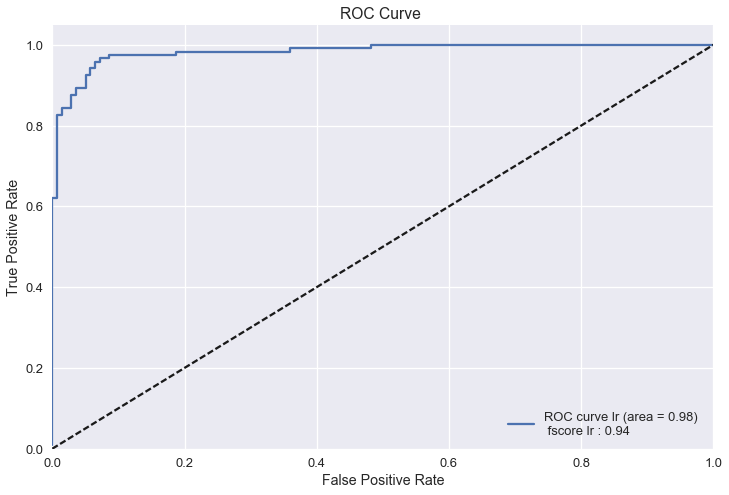

In [91]:
accuracy_model_with_roc( train_data['processed_comment'], train_data['Class'])